In [167]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, List
import random
import math

np.random.seed(42)

In [168]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1
    
    def __rtruediv__(self, other): # other / self
        return (self**-1) * other

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other):  # other - self
        return -self + other

    def __radd__(self, other):  # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += (
                out.data * out.grad
            )  # NOTE: in the video I incorrectly used = instead of +=. Fixed here.

        out._backward = _backward

        return out

    def log(self):
        out = Value(math.log(self.data), _children=(self,), _op="log")

        def _backward():
            self.grad += (self.data**-1) * out.grad

        out._backward = _backward
        return out

    def sigmoid(self):
        sig = 1 / (1 + math.exp(-self.data))
        out = Value(sig, _children=(self,), _op="sigmoid")

        def _backward():
            self.grad += (sig * (1 - sig)) * out.grad

        self.backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [190]:
class Neuron:
    def __init__(self, nin, is_last=False) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        self.is_last = is_last

    def __call__(self, x) -> Any:
        # w * x + b
        act = sum(wi * xi for wi, xi in zip(self.w, x)) + self.b

        # if self.is_last:
        #     return act.sigmoid()

        out = act.tanh()  # NOTE: tanh is usually used inside activation hidden layers to introduce non-linearity while maintaining zero-centered output.
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout, is_last=False) -> None:
        self.neurons = [Neuron(nin, is_last) for _ in range(nout)]

    def __call__(self, x: Any) -> Any:
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin: int, nouts: List[int]) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1], is_last=(i == len(nouts) - 1)) for i in range(len(nouts))]

    def __call__(self, x: Any) -> Any:
        for layer in self.layers:
            x = layer(x)

        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


# Training the MLP
def train(mlp, X, y, epochs=50, lr=0.01, decay=0.1, decay_step=100):

    loss_history = []
    for k in range(epochs):

        # forward pass
        ypred = [mlp(x) for x in X]
        # l2reg = sum([p**2 for p in mlp.parameters()])
        loss = sum([(yout - ytrue) ** 2 for yout, ytrue in zip(ypred, y)]) # + l2reg  # mse loss
        # loss = -sum([ytrue * (yout + 1e-07).log() + (1 - ytrue) * (1 - yout + 1e-07).log() for yout, ytrue in zip(ypred, y)]) / len(ypred)  # bce_loss
        # NOTE: do not use tanh with the bce loss as it has neg values and bce cant have neg values
        
        loss_history.append(loss)
        
        # backward pass
        for p in mlp.parameters():
            p.grad = 0.0  # we get slower results

        loss.backward()

        # update
        for p in mlp.parameters():
            p.data += -lr * p.grad

        if (k + 1) % decay_step == 0:
            print(
                f"Decaying the learning rate from {lr} to {lr * decay} at step {k+1}."
            )
            lr *= decay

        if (k + 1) % 10 == 0:
            print(f"Step {k+1}: loss: {loss.data}")

    return loss_history

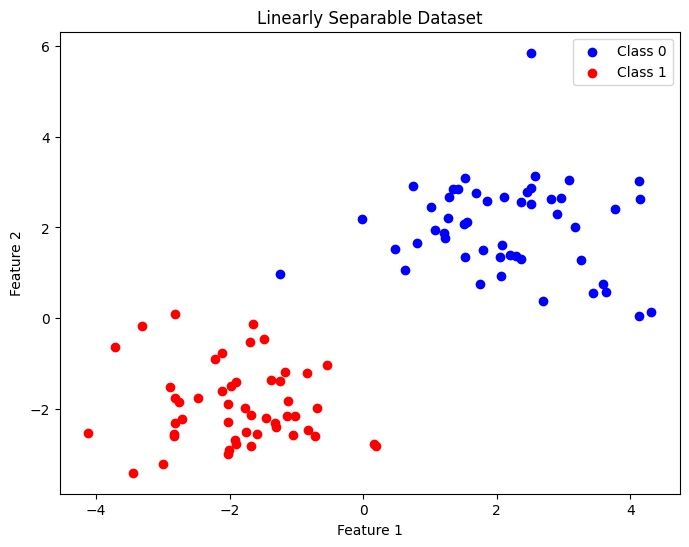

In [191]:
# Generate points for class 0
class_0 = np.random.randn(50, 2) + np.array([2, 2])
# Generate points for class 1
class_1 = np.random.randn(50, 2) + np.array([-2, -2])

# Combine the points into a single dataset
X = np.vstack((class_0, class_1)).tolist()
y = np.hstack((np.zeros(50), np.ones(50))).tolist()

plt.figure(figsize=(8, 6))
plt.scatter(class_0[:,0], class_0[:,1], color='blue', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='red', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linearly Separable Dataset')
plt.legend()
plt.show()

In [192]:
# Create and train the MLP
mlp = MLP(2, [4, 4, 1])
loss_history = train(mlp, X, y, epochs=100)    # TODO: implement different loss funcs

Step 10: loss: 6.013250632094401
Step 20: loss: 10.191556438895677
Step 30: loss: 9.457701533953253
Step 40: loss: 9.717745602197825
Step 50: loss: 10.973045606494091
Step 60: loss: 11.398744422946658
Step 70: loss: 10.937446130775722
Step 80: loss: 9.70286465424319
Step 90: loss: 5.31139882614588
Decaying the learning rate from 0.01 to 0.001 at step 100.
Step 100: loss: 1.4844557735152994


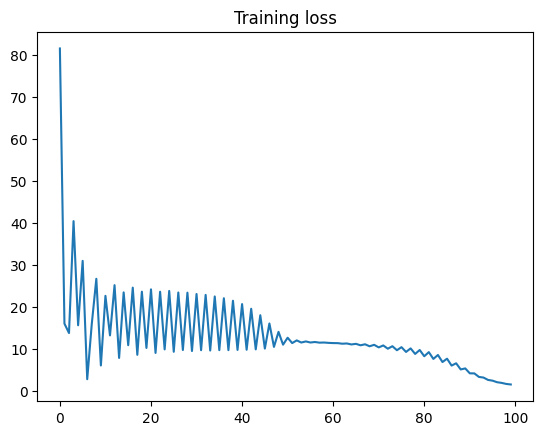

In [198]:
plt.plot([v.data for v in loss_history])
plt.title("Training loss")
plt.show()

In [194]:
# # Generate grid of points
xx, yy = np.meshgrid(np.linspace(-6, 6, 100), np.linspace(-6, 6, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict class probabilities for each point in the grid
Z = np.array([mlp([Value(xi[0]), Value(xi[1])]).data for xi in grid])
Z = Z.reshape(xx.shape)

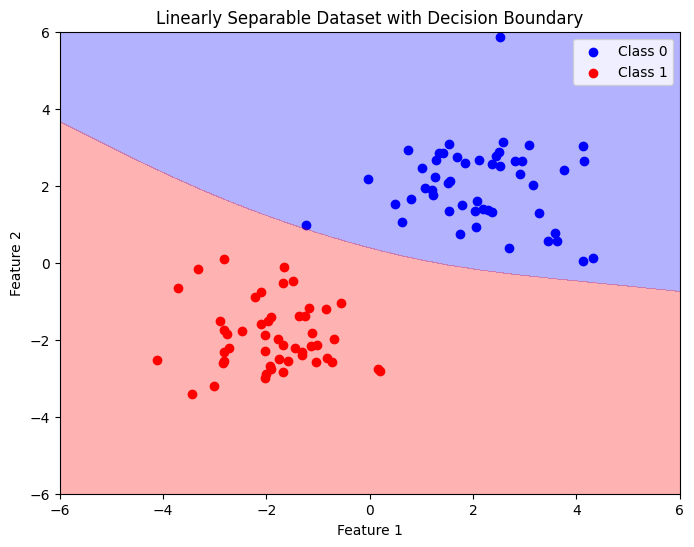

In [195]:
# Plot the dataset and decision boundary
# X_np, y_np = np.array(X), np.array(y)   # we make them array so that we can take out the indices from y with 0 and 1 values
plt.figure(figsize=(8, 6))
# plt.scatter(X_np[y_np==0][:, 0], X_np[y_np==0][:, 1], color='blue', label='Class 0')
# plt.scatter(X_np[y_np==1][:, 0], X_np[y_np==1][:, 1], color='red', label='Class 1')
plt.scatter(class_0[:,0], class_0[:,1], color='blue', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='red', label='Class 1')
# NOTE: contourf fills the separated areas with the specified colors
plt.contourf(xx, yy, Z, levels=0, alpha=0.3, colors=["blue", "red"])
# NOTE: while there were levels [-1, 0, 1] it was understood that the tanh activation would be between -1 to 1 where 0 is the model being equally uncertain about both classes
# plt.contour(xx, yy, Z, levels=1, alpha=0.3, colors=["blue", "red"])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linearly Separable Dataset with Decision Boundary')
plt.legend()
plt.show()

In [50]:
# DEBUG down

xx, yy = np.meshgrid(np.linspace(-6, 6, 100), np.linspace(-6, 6, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict class probabilities for each point in the grid
Z = np.array([mlp([Value(xi[0]), Value(xi[1])]).data for xi in grid])
# Z = Z.reshape(xx.shape)
Z.shape, xx.shape

((10000,), (100, 100))

In [31]:
grid

# plt.scatter(grid[:, 0], grid[:, 1], c="green", marker="+")
# plt.show()
np.all(grid.ravel() == grid.flatten())

True

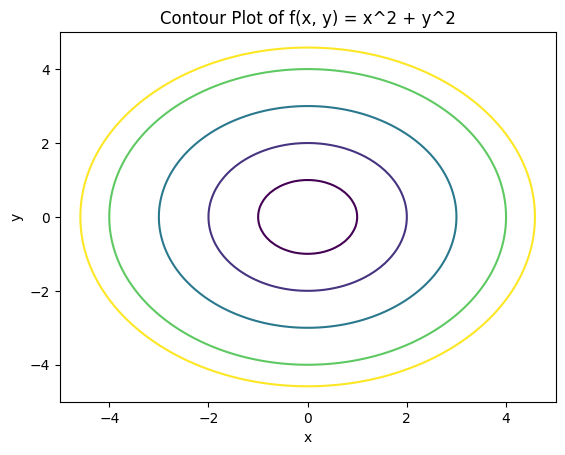

In [52]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
xx, yy = np.meshgrid(x, y)
zz = xx**2 + yy**2

plt.contour(xx, yy, zz, levels=[1, 4, 9, 16, 21])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour Plot of f(x, y) = x^2 + y^2')
plt.show()